# Starlink Forecast


In [1]:
from datetime import date, datetime
import requests
import math
from os import path,remove
import numpy as np
from cysgp4 import *
import pandas as pd
import altair as alt
from altair_saver import save
alt.renderers.enable('altair_saver', fmts=['vega-lite', 'png','svg'])

today = date.today()
starlink_url = 'http://celestrak.com/NORAD/elements/starlink.txt'
starlink_file_tle = "../data/in/starlink_%s.tle"%today
starlink_file_json = "../data/out/starlink_forecast_%s.json"%today
starlink_file_png = "../data/out/starlink_forecast_%s.png"%today
starlink_file_svg = "../data/out/starlink_forecast_%s.svg"%today


if not path.exists(starlink_file_tle):
    r = requests.get(starlink_url, allow_redirects=True)
    open(starlink_file_tle, 'wb').write(r.content)
    print("Fetching",starlink_url )
else:
    print("Using",starlink_file_tle)
    
    
with open(starlink_file_tle , 'r') as tlefile:
        starlink_tle_text = '\r\n'.join(tlefile.read().split('\n'))

tles = np.array(tles_from_text(starlink_tle_text))
print('Read %i TLEs'%len(tles))

Using ../data/in/starlink_2020-11-01.tle
Read 792 TLEs


In [12]:
DAY = 24*60*60
EARTH_RADIUS = 6378137.0
EARTH_MASS = 3.986004418 * 10**14

operational=None

for tle in tles:
    period = DAY /tle.mean_motion
    semi_major_axis = (((period / (math.pi*2))**2) * EARTH_MASS) ** (1/3)
    ap_plus_pe = semi_major_axis * 2
    ap_minus_pe = tle.eccentricity * ap_plus_pe
    apogee = (ap_plus_pe + ap_minus_pe) / 2
    perigee = apogee - ap_minus_pe

    apogee -= EARTH_RADIUS
    perigee -= EARTH_RADIUS
    
    if apogee > 550000:
        if operational is not None:
            operational=np.append(operational,tle)
        else:
            operational=np.array(tle)
            

print("Found %i operational Starlink satellites"% len(operational))

Found 514 operational Starlink satellites


In [3]:
lon=-120
lat_min=43
lat_max=53
lat_step=.25
height=0
days=1 
steps=int(days*24*4) +1
start=datetime.combine(date.today(), datetime.min.time())

pydt = PyDateTime(start)
mjds = np.linspace(pydt.mjd, pydt.mjd+days, steps)

observers = None
for lat in np.arange(lat_max,lat_min-lat_step,-lat_step):
    if observers is not None:
        observers = np.append(observers, PyObserver(lon, lat, height))
    else:
        observers=np.array([PyObserver(lon, lat, height)])

In [4]:
result = propagate_many(
     mjds[:, np.newaxis, np.newaxis],
     operational[np.newaxis, np.newaxis, :],
     observers[np.newaxis, :, np.newaxis],
     do_eci_pos=False, do_eci_vel=False, do_geo=False, do_topo=True
     )
topo_pos = result['topo']
topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., i] for i in range(4))
topo_pos_az = (topo_pos_az + 180.) % 360. - 180.
result_topo=np.column_stack([topo_pos_az[0, 0, :], topo_pos_el[0, 0, :]])

In [5]:
def reachable(topo):
    reachable=0
    for r in topo:
        azimuth,elevation=r
        if (elevation > 35 and (azimuth > -60 and azimuth < 60)) or (elevation > 45 and (azimuth > -120 and azimuth < 120)) or elevation  > 55:
            reachable+=1
    return(reachable)

sat_reachable={
    'time':[],
    'lat':[],
    'sat':[]
}
for l in range(0,len(topo_pos_az[0])):
    for i in range(0,len(topo_pos_az)):
        pydt= PyDateTime.from_mjd(mjds[i])
        topo=np.column_stack([topo_pos_az[i, l, :], topo_pos_el[i, l, :]])
        sat_reachable['time'].append(pydt.datetime.strftime("%H:%M"))
        sat_reachable['lat'].append('{:.2f}'.format(observers[l].loc.lat))
        sat_reachable['sat'].append(reachable(topo))

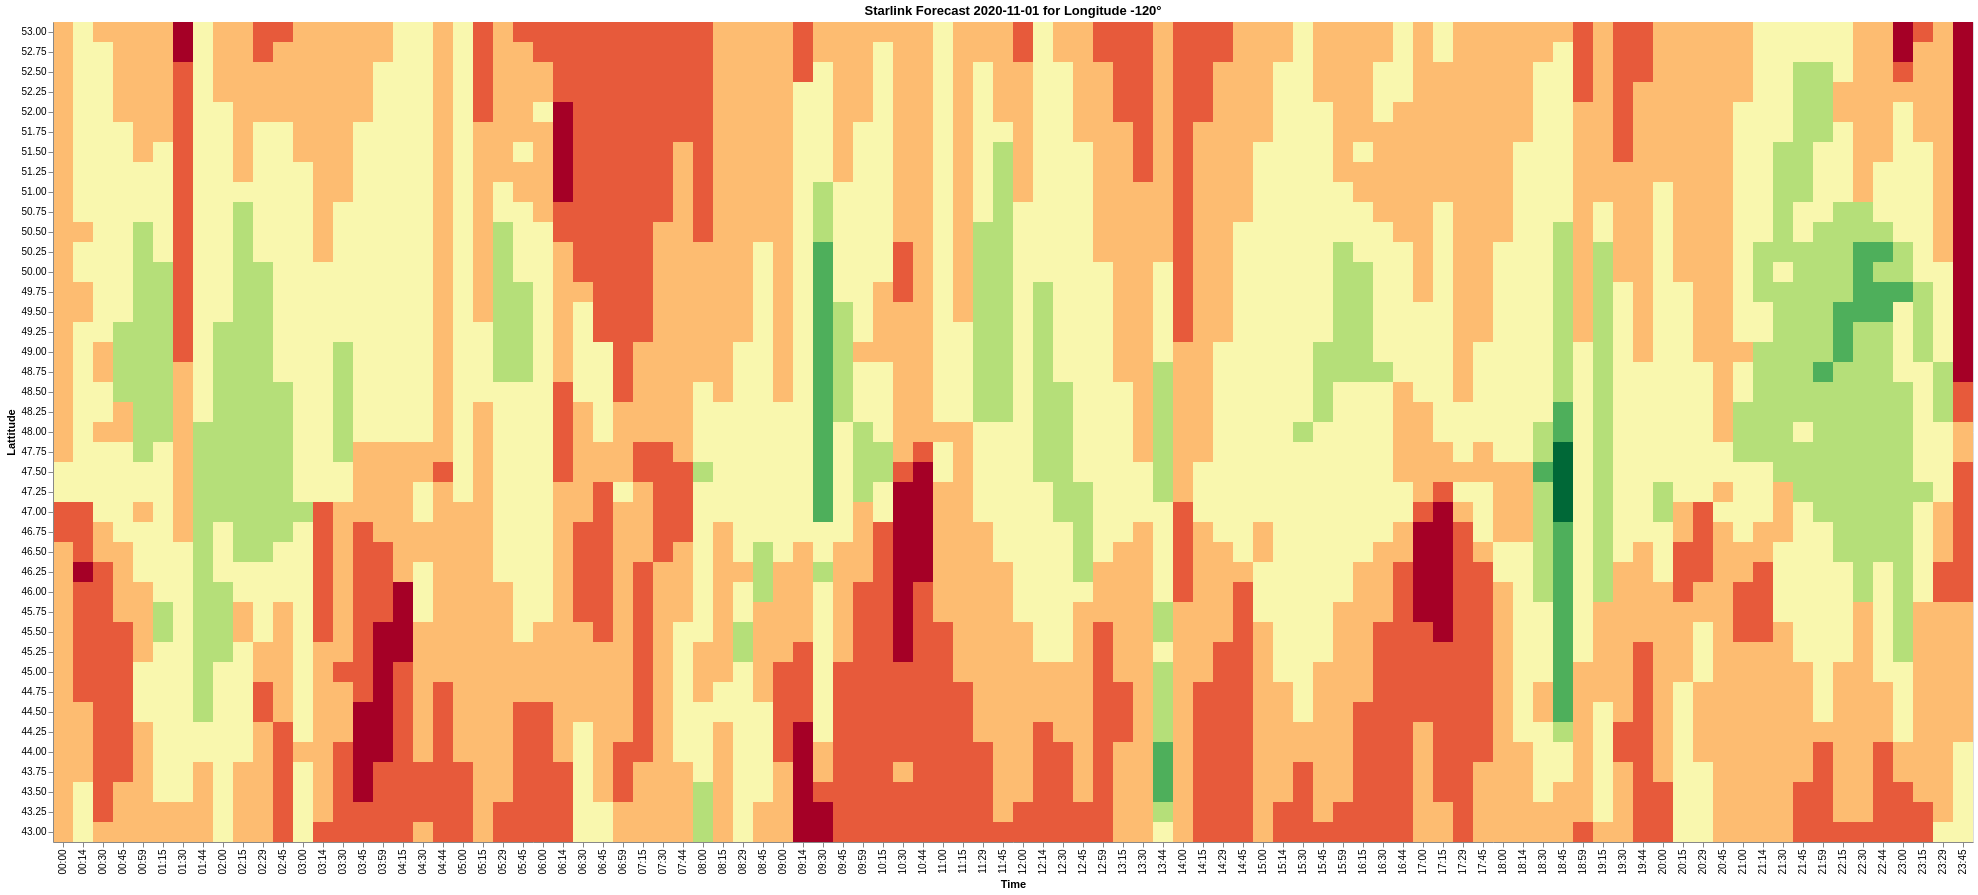

In [6]:
df=pd.DataFrame(sat_reachable)
chart=alt.Chart(df).mark_rect().encode(
    x=alt.X('time:O', axis=alt.Axis( title='Time')),
    y=alt.Y('lat:O', axis=alt.Axis( title='Lattitude'),sort='descending'),
    color=alt.Color('sat', scale=alt.Scale(scheme='redyellowgreen'),legend=None),
    tooltip=['time','lat','sat'],
).properties(
    title='Starlink Forecast %s for Longitude %s°'%(today,lon)
).configure_header(
    titleFontSize=30,
)
chart

In [7]:
save(chart, starlink_file_json)
save(chart, starlink_file_png)
save(chart, starlink_file_svg)